# Lesson 1 - Pets

## What is our goal today?

* Make an image classifier for Cats and Dogs
* Make our own image classifier
* Start to understand the DataBlock API

## Let's grab the library:

In [1]:
import fastai
print(fastai.__version__)

2.7.12


Today we will be using the `basics`, `callback`, and `vision` libraries as we have a **vision** task

In [2]:
from fastai.basics import * # for all basic functionality
from fastai.vision.all import * # for all vision-related functionality
from fastai.callback.all import * # for all callback-related functionality

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Below you will find the exact imports for everything we use today

In [3]:
# Importing numpy and aliasing it as np
import numpy as np

# This class provides additional functionality to the Pathlib module
from fastcore.xtras import Path

# For mixed-precision training
from fastai.callback.fp16 import to_fp16

# Importing functions for fitting one cycle and finding an optimal learning rate
from fastai.callback.schedule import fit_one_cycle, lr_find

# For defining data blocks and data loaders
from fastai.data.block import CategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, Normalize, RandomSplitter, RegexLabeller

# For interpreting classification results
from fastai.interpret import ClassificationInterpretation

# For creating and training machine learning models
from fastai.learner import Learner

# The error_rate metric for classification tasks
from fastai.metrics import error_rate

# Data augmentation transforms and core functions for image processing
from fastai.vision.augment import aug_transforms, RandomResizedCrop
from fastai.vision.core import imagenet_stats

# For defining image data loaders and blocks
from fastai.vision.data import ImageDataLoaders, ImageBlock

# For creating convolutional neural network models
from fastai.vision.all import vision_learner

# Pre-defined ResNet models from torchvision
from torchvision.models.resnet import resnet34, resnet50

Overall process using machine learning models and fastai:
1. Make our `DataLoaders`
2. Make a `Learner` with some "equipment"
3. Train

## Looking at Data

We'll be trying to identify between 12 species of cats and 25 species of dogs (37 in total). Five years ago, the best was 59% with seperate classifications for the image, head, and body of the animal. (i.e. They reached the 59% accuracy by analyzing images in three parts: the whole animal, its head, and its body, as separate components). But now, let's try just doing one image for everything.

But before anything, we need data!

### untar_data
This function is used to download and extract data from a specified URL and store it in a local directory.

The function parameters and what it does:

1. `url: str`: required parameter and represents the URL from which the data is to be downloaded.

2. `archive: Path = None`: optional parameter and represents the local path where the downloaded data archive (e.g., a compressed file) should be stored. If not provided, the archive will be stored in the current working directory.

3. `data: Path = None`: optional parameter and represents the local directory where the extracted data will be stored. If not provided, the data will be extracted in the current working directory.

4. `c_key: str = 'data'`: optional parameter and represents the key to identify the downloaded data.

5. `force_download: bool = False`: optional parameter that, if set to `True`, forces the download even if the data is already present locally.

6. `base: str = '~/.fastai'`: base directory where fastai stores its data by default. If you don't specify the `data` parameter, the data will be extracted to a subdirectory within this base directory.

The primary purpose of this function is to download the data from the specified URL using the `FastDownload.get` method provided by fastai. It typically retrieves datasets that are commonly used in machine learning and deep learning tasks. By providing the URL, you can easily fetch and work with datasets in your fastai-based projects.

If we call `help` on `untar_data` we can see it's doc description

In [4]:
help(untar_data)

Help on function untar_data in module fastai.data.external:

untar_data(url: 'str', archive: 'Path' = None, data: 'Path' = None, c_key: 'str' = 'data', force_download: 'bool' = False, base: 'str' = '~/.fastai') -> 'Path'
    Download `url` using `FastDownload.get`



We can also pull up the source code by adding a `??` at the end:

In [5]:
untar_data??

Let's download the `PETS` dataset

In [6]:
# folder structure before downloading the PETS dataset
!tree /kaggle

/kaggle
├── input
├── lib
│   └── kaggle
│       └── gcp.py
├── src
│   └── script.ipynb
└── working
    └── __notebook__.ipynb

5 directories, 3 files


In [7]:
print(URLs.PETS)

https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz


In [8]:
path = untar_data(URLs.PETS)
print(path)

/root/.fastai/data/oxford-iiit-pet


In [9]:
# folder structure after downloading the PETS dataset
!tree -d /root/.fastai/data/

!ls -sh /root/.fastai/data/

/root/.fastai/data/
└── oxford-iiit-pet
    ├── annotations
    │   ├── trimaps
    │   └── xmls
    └── images

5 directories
total 4.0K
4.0K oxford-iiit-pet


And set our seed

In [10]:
np.random.seed(42)

How will our data look?

In [11]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

Let's build a `DataLoaders`. First we'll need the `path` to our data, some filenames, and the regex pattern to extract our labels:

In [12]:
from fastai.data.transforms import get_image_files

path = untar_data(url = URLs.PETS)
fnames = get_image_files(path = path/'images')
print(f"Total {len(fnames)} images, {fnames[:10]} ...")
pat = r'(.+)_\d+.jpg$'

Total 7390 images, [Path('/root/.fastai/data/oxford-iiit-pet/images/beagle_115.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_18.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_157.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_28.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/english_setter_6.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_79.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_128.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/Persian_265.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_182.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/keeshond_89.jpg')] ...


```python
Below is what the regular expression pattern r'(.+)_\d+.jpg$' helps to achieve

Label for '/root/.fastai/data/oxford-iiit-pet/images/beagle_115.jpg': beagle
Label for '/root/.fastai/data/oxford-iiit-pet/images/boxer_18.jpg': boxer
Label for '/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_157.jpg': Maine_Coon
Label for '/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_28.jpg': scottish_terrier
Label for '/root/.fastai/data/oxford-iiit-pet/images/english_setter_6.jpg': english_setter
Label for '/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_79.jpg': american_pit_bull_terrier
Label for '/root/.fastai/data/oxford-iiit-pet/images/boxer_128.jpg': boxer
```

Some  basic transforms for getting all of our images the same size (`item_tfms`), and some augmentations and Normalization to be done on the GPU (`batch_tfms`)

In [13]:
from fastai.vision.augment import aug_transforms, RandomResizedCrop
from fastai.data.transforms import Normalize
from fastai.vision.core import imagenet_stats

# crop and resize the image, focusing on a specific part while maintaining the original aspect ratio
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
#  apply various transformations and ensure that the image is suitable for training a neural network
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=64

`*` operator can be used to (unpack) pass elements of a list (or any iterable) as separate arguments to a function.
1. **Item Transforms (`item_tfms`)**:
   - `RandomResizedCrop(460, min_scale=0.75, ratio=(1., 1.))`: Takes an image and randomly crops it to a size of 460x460 pixels, keeping the original aspect ratio. This is good for focusing on a specific part of the image.

2. **Batch Transforms (`batch_tfms`)**:
   - `[*aug_transforms(size=224, max_warp=0)]`: Adds variety to the images in a batch with operations like flips and rotations. After that, it resizes them to 224x224 pixels.
   - `Normalize.from_stats(*imagenet_stats)`: Adjusts the color values of the images to help neural networks learn more effectively.

3. **Batch Size (`bs=64`)**:
   - Sets the number of images processed together as a batch during training. In this case, it's 64 images at a time.

`ImageDataBunch` (renamed to ImageDataLoaders) - highest level API

In [14]:
from fastai.vision.data import ImageDataLoaders

# load and preprocess image data for deep learning tasks
dls = ImageDataLoaders.from_name_re(path=path, 
                                    fnames=fnames, 
                                    pat=pat, 
                                    batch_tfms=batch_tfms,
                                    item_tfms=item_tfms, 
                                    bs=bs)

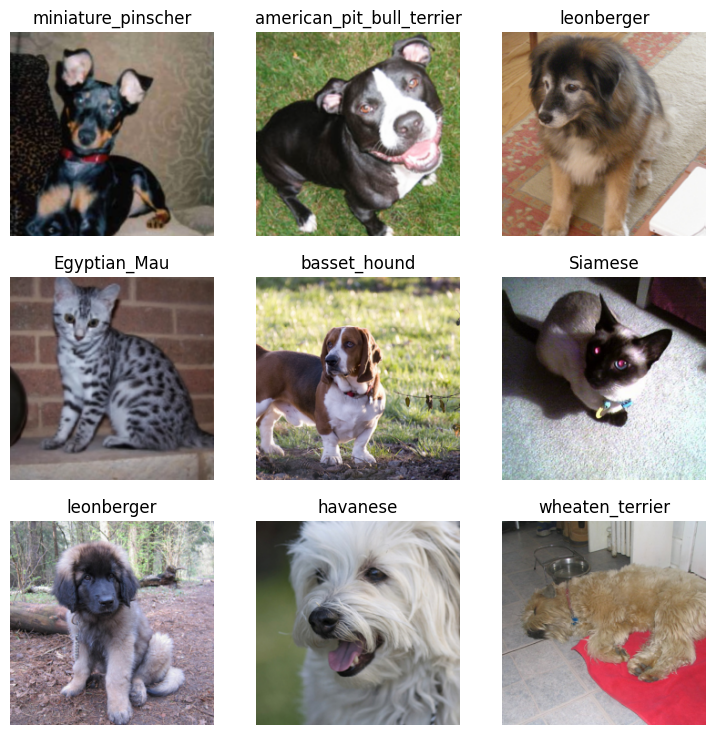

In [15]:
# visualize the preprocessed image
dls.show_batch()

What is the API?

* [See PPT](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/01_Slides.pdf)

Let's rebuild using the `DataBlock` API

We'll need to define what our input and outputs should be (An `Image` and a `Category` for classification), how to get our items, how to split our data, how to extract our labels, and our augmentation as before

In [16]:
from fastai.vision.data import ImageBlock
from fastai.data.block import CategoryBlock, DataBlock

pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*'),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

dls = pets.dataloaders(source=path/'images', bs=bs)

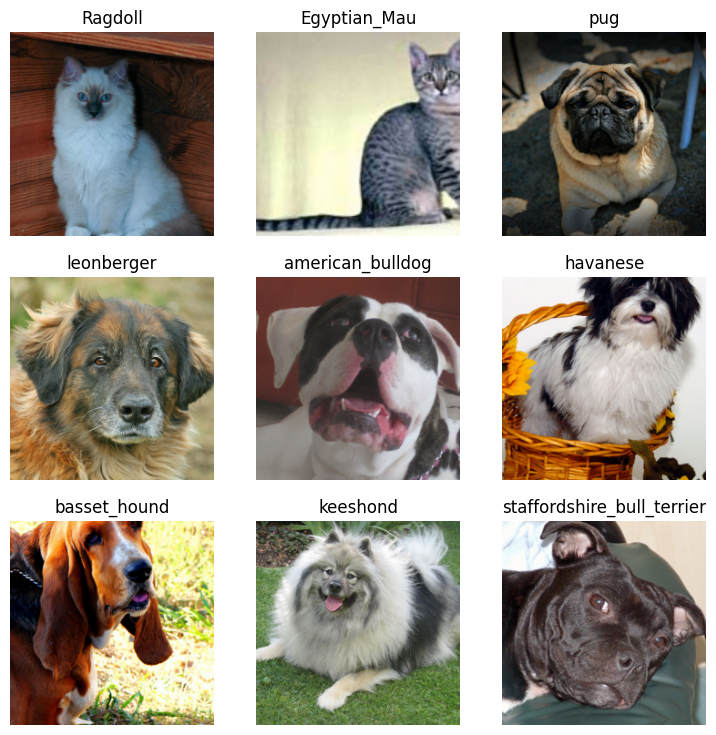

In [17]:
# visualize the preprocessed image
dls.show_batch()

If we want to see how many classes we have, and the names of them we can simply call `dls.vocab`. The first is the number of classes, the second is the names of our classes. You may notice this looks a bit odd, that's because this `L` is a new invention of Jeremy and Sylvian. Essentially it's a Python list taken to the extreme.

Before if we wanted to grab the index for the name of a class (eg. our model output 0 as our class), we would need to use `data.c2i` to grab the Class2Index mapping. This is still here, it lives in `dls.vocab.o2i`

In [18]:
print(f"{len(dls.vocab)} {dls.vocab}")

37 ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [19]:
dls.vocab.o2i

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

## Time to make and train a model!

We will be using a convolutional neural network backbone and a fully connected head with a single hidden layer as our classifier. Don't worry if thats a bunch of nonsense for now. Right now, just know this: we are piggybacking off of a model to help us classify images into 37 categories.

First, we need to make our Neural Network and our `Learner` like before.

A `Learner` needs (on a base level):

* `DataLoaders`
* Some architecture
* A evaluation metric
* A loss function
* An optimizer

We'll also use `mixed_precision` (`fp16`)

OR

In FastAI, to create a basic `Learner`, you typically need the following components:

1. **DataLoaders**: You need to prepare your data and create DataLoaders. DataLoaders contain your training and validation data and provide batches of data for training and evaluation. You can use `ImageDataLoaders`, `TextDataLoaders`, or other DataLoaders depending on your data type.

2. **Architecture**: You'll need to choose an architecture or neural network model for your task. FastAI provides a collection of pre-trained models for computer vision, natural language processing, and tabular data. You can use these models as a starting point or create your own custom architecture using FastAI's neural network building blocks.

3. **Evaluation Metric**: You should specify an evaluation metric that helps you measure the performance of your model during training and validation. Common metrics for different tasks include accuracy, F1-score, mean squared error (MSE), etc. You can use FastAI's built-in metrics or define a custom metric if needed.

4. **Loss Function**: You need to choose an appropriate loss function that quantifies the difference between the model's predictions and the ground truth labels. The choice of loss function depends on your task. FastAI provides various loss functions, and you can also define custom loss functions if necessary.

5. **Optimizer**: You must select an optimizer that updates the model's parameters during training to minimize the loss function. Common optimizers include Stochastic Gradient Descent (SGD), Adam, and RMSprop. FastAI provides different optimizers that you can configure.

In [20]:
from fastai.callback.fp16 import to_fp16# Mixed Precision training
from fastai.vision.all import vision_learner
from torchvision.models.resnet import resnet34, resnet50 # Pre-defined ResNet models from torchvision
from fastai.metrics import error_rate # error_rate metric for classification tasks

learn = vision_learner(dls=dls, 
                       arch=resnet34, 
                       pretrained=True, 
                       metrics=error_rate).to_fp16()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 213MB/s]


Some assumptions being made here:

* Loss function is assumed as classification, so `CrossEntropyFlat`
* Optimizer is assumed to be Adam

Now, we can train it! We will train it for four cycles through all our data

In [21]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.875198,0.401028,0.127876,01:02
1,0.652451,0.298290,0.097429,00:58
2,0.373619,0.258258,0.076455,00:58
3,0.281234,0.253948,0.081191,00:58


In [22]:
learn.save('stage_1')

Path('models/stage_1.pth')

## Lets look at our results

With the model trained, let's look at where our it might've messed up. What species did it have trouble differentiating between? So long as the misidentifications are not too crazy, our model is actually working.

Let's plot our losses and make a confusion matrix to visualize this. Below checks to make sure that all pieces we need are available

In [23]:
# For interpreting classification results
from fastai.interpret import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(dls.valid_ds)==len(losses)==len(idxs)

True

`plot_top_losses` needs `x` number of images to use, and a figure size.

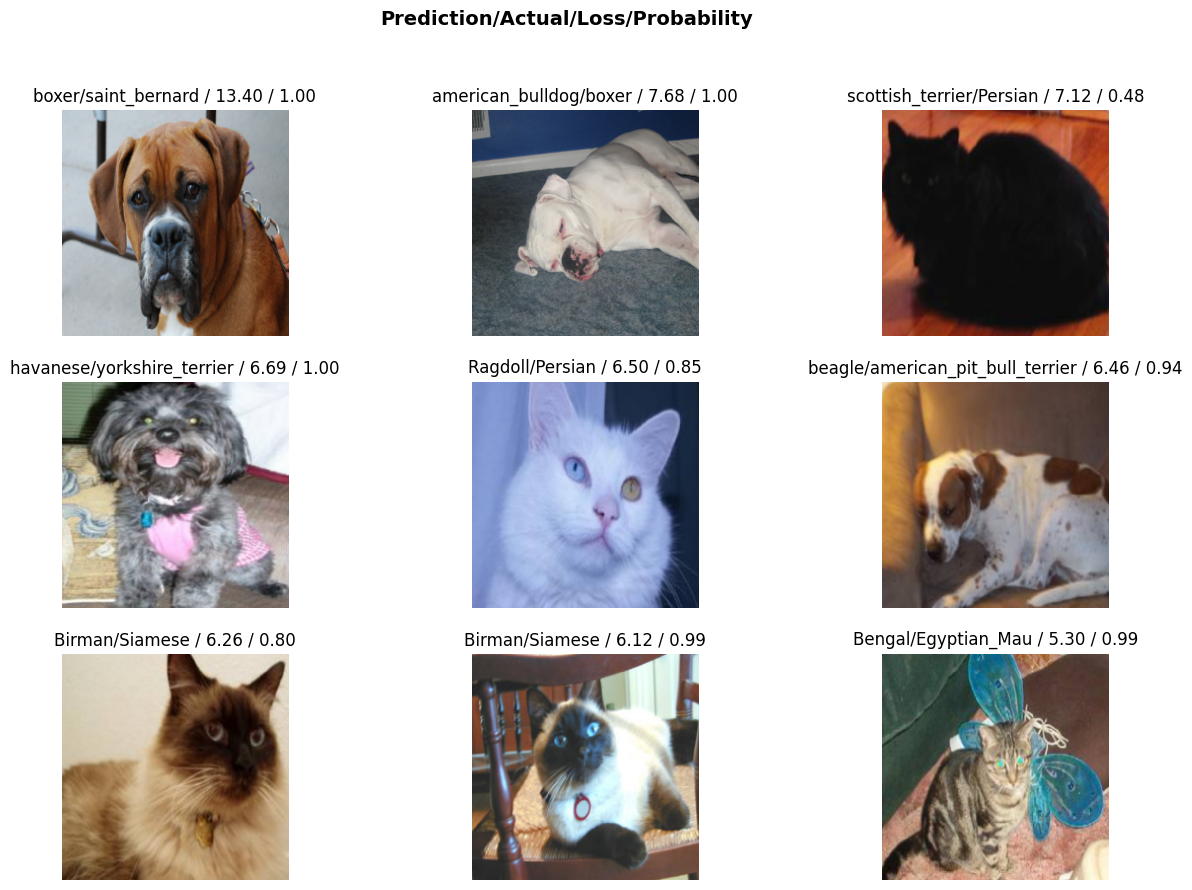

In [24]:
interp.plot_top_losses(k=9, figsize=(15,10))

`plot_confusion_matrix` just needs a figure size. dpi adjusts the quality

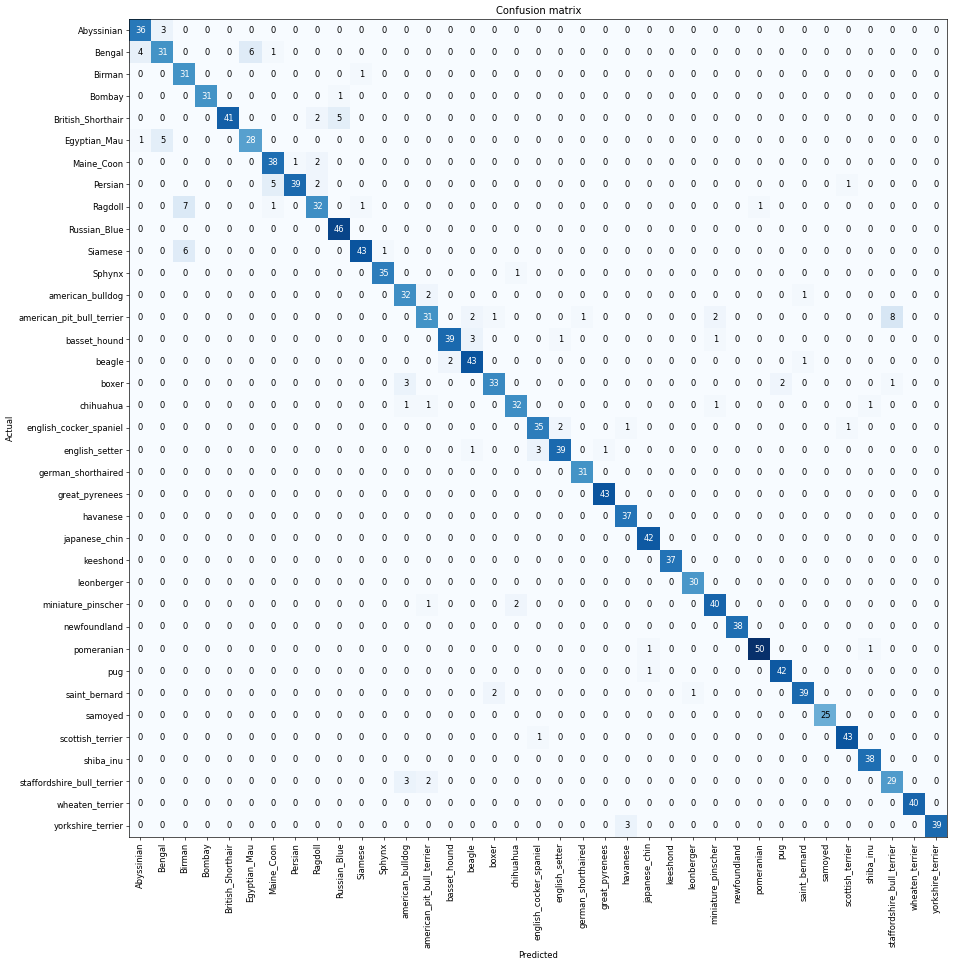

In [25]:
interp.plot_confusion_matrix(figsize=(16,16), dpi=60)

We can also directly grab our most confused (A raw version of the confusion matrix), and pass in a threshold

In [26]:
interp.most_confused(min_val=3)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 8),
 ('Ragdoll', 'Birman', 7),
 ('Bengal', 'Egyptian_Mau', 6),
 ('Siamese', 'Birman', 6),
 ('British_Shorthair', 'Russian_Blue', 5),
 ('Egyptian_Mau', 'Bengal', 5),
 ('Persian', 'Maine_Coon', 5),
 ('Bengal', 'Abyssinian', 4),
 ('Abyssinian', 'Bengal', 3),
 ('basset_hound', 'beagle', 3),
 ('boxer', 'american_bulldog', 3),
 ('english_setter', 'english_cocker_spaniel', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('yorkshire_terrier', 'havanese', 3)]

## Unfreezing our data, fine-tuning, and our learning rates
**Unfreezing the Model:** When you initially create a FastAI Learner with a pre-trained model, all layers except the custom head (classification layers) are frozen by default. This means that these layers are not updated during training, and only the custom head is trained. To fine-tune the entire model, including the pre-trained layers, you need to "unfreeze" those layers.

By unfreezing the model and setting appropriate learning rates, you allow the model to fine-tune its parameters, leveraging both the pre-trained knowledge and the task-specific data. Fine-tuning often leads to improved performance on your specific task.

So, we have the model. Let's fine tune it. First, we need to load our model back in.

In [27]:
learn.load('stage_1');

Now we will *unfreeze* and train more

In [28]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.205465,2.688056,0.598782,01:00
1,1.060298,1.158658,0.332882,01:00
2,0.594333,0.525995,0.169147,01:00
3,0.295429,0.387106,0.129905,01:00


Now when we `unfreeze`, we unfreeze *all* the layers. So to show how a difference of a proper learning rate looks, let's load in those old weights and try using `lr_find()`

In [30]:
learn.load('stage_1');

SuggestedLRs(valley=3.0199516913853586e-05)

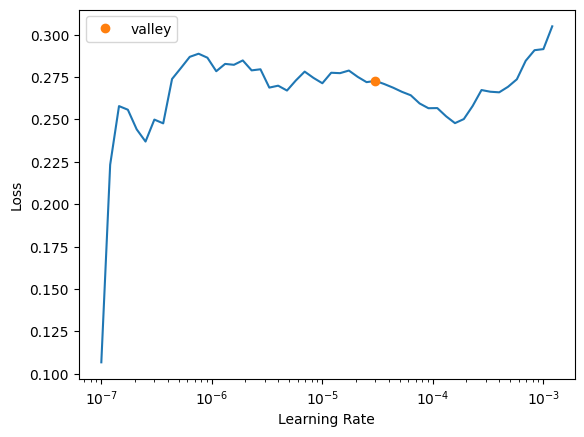

In [31]:
learn.lr_find()

Alright so if we look here, we don't start really spiking our losses until ~10^-2 so a good spot is between 1e-6 and 1e-4, let's do that!

In [32]:
learn.unfreeze()
lr = slice(1e-6, 1e-4)  # Smaller LR for earlier layers, larger LR for later layers

learn.fit_one_cycle(4, lr_max=lr)

epoch,train_loss,valid_loss,error_rate,time
0,0.255470,0.253648,0.081867,01:00
1,0.238410,0.249826,0.075778,01:00
2,0.203260,0.240541,0.073072,01:00
3,0.170346,0.236274,0.073748,00:59


We can see that picking a proper learning rate can help speed things up!

In [33]:
learn.save('stage_2')

Path('models/stage_2.pth')

## Now lets try with a resnet50!

If you need to restart your kernel due to memory errors I've attached the `dls` code below

In [34]:
# pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
#                  get_items=get_image_files,
#                  splitter=RandomSplitter(),
#                  get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*'),
#                  item_tfms=item_tfms,
#                  batch_tfms=batch_tfms)

# dls = pets.dataloaders(untar_data(URLs.PETS)/"images", bs=32)

Go ahead and try running the below code yourself. You *should* see a higher increase in accuracy!

Steps to try:

1. Create your Learner
2. Find a learning rate
3. Fit for 5 epochs
4. Unfreeze and fit for two more

In [35]:
### Try here! ###
# Create your Learner
from torchvision.models.resnet import resnet50 # Pre-defined ResNet models from torchvision

learn = vision_learner(dls=dls, 
                       arch=resnet50, 
                       pretrained=True, 
                       metrics=error_rate).to_fp16()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s]


SuggestedLRs(valley=0.0004786300996784121)

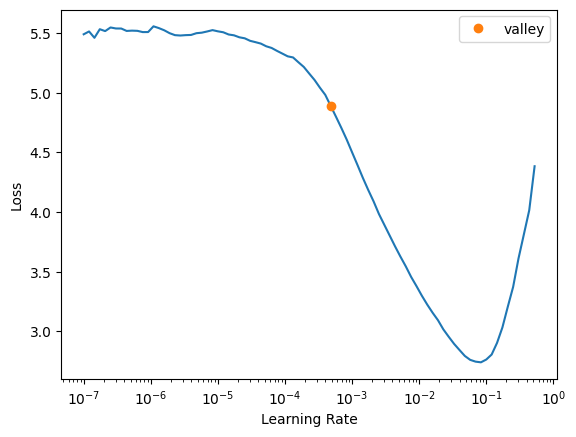

In [36]:
# Find a learning rate
learn.lr_find()

In [37]:
# Fit for 5 epochs
lr = slice(1e-5,1e-3)
learn.fit_one_cycle(n_epoch = 5, lr_max=lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.201551,0.348947,0.112314,01:03
1,0.495029,0.291118,0.090663,01:03
2,0.297985,0.254729,0.075778,01:02
3,0.189914,0.248122,0.074425,01:02
4,0.148142,0.236754,0.072395,01:02


In [38]:
# save the model
learn.save("model1_res50")

Path('models/model1_res50.pth')

In [39]:
# unfreeze and train
learn.load("model1_res50")
learn.unfreeze()
lr = slice(1e-5,1e-3)
learn.fit_one_cycle(n_epoch = 5, lr_max=lr)

epoch,train_loss,valid_loss,error_rate,time
0,0.221656,0.499744,0.130582,01:04
1,0.291709,0.347494,0.087957,01:04
2,0.168362,0.314371,0.085250,01:04
3,0.086059,0.263454,0.070365,01:04
4,0.041724,0.262143,0.069012,01:04


## The answer is hidden under here

In [40]:
learn = cnn_learner(dls, resnet50, pretrained=True, metrics=error_rate)

/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


SuggestedLRs(valley=0.0003981071640737355)

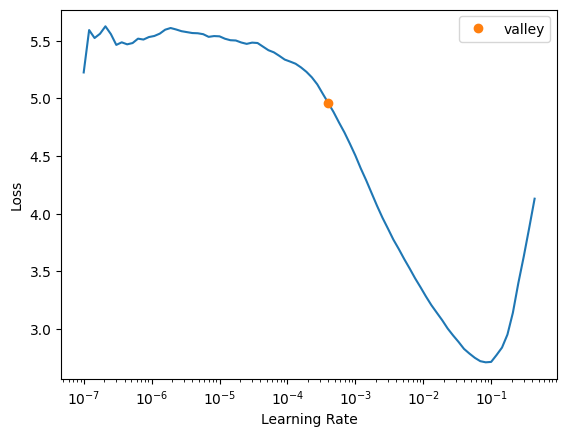

In [41]:
learn.lr_find()

In [42]:
learn.fit_one_cycle(5, lr_max=slice(3e-4, 3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.806594,0.356692,0.112991,01:14
1,0.439996,0.296989,0.082544,01:13
2,0.234143,0.237929,0.069012,01:14
3,0.144203,0.213430,0.064276,01:13
4,0.106395,0.215239,0.070365,01:13


In [43]:
learn.save('resnet50')

Path('models/resnet50.pth')

In [44]:
learn.load('resnet50')
learn.unfreeze()
learn.fit_one_cycle(2, lr_max=slice(3e-4, 3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.339456,1.519312,0.388363,01:20
1,0.662613,0.442417,0.133965,01:20


In [45]:
learn.save('resnet50')

Path('models/resnet50.pth')